# Decode keypoints from neural data

In [4]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("../../")

import pyaldata as pyal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from tools.reports.report_initial import run_initial_report
from tools.params import Params, colors
from tools.dsp.preprocessing import preprocess
import tools.viz.mean_firing as firing
import tools.viz.dimensionality as dim
import tools.viz.rrr as viz_rrr
import tools.viz.utilityTools as vizutils
import tools.decoding.rrr as rrr

import tools.decoding.decodeTools as decutils
import tools.dataTools as dt

import torch





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
data_dir = "/data/bnd-data/raw/"
session = 'M062_2025_03_21_14_00'

df = pyal.load_pyaldata(data_dir + session[:4] + '/' + session)
df = preprocess(df, only_trials=False, combine_time_bins=False)

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
field values_Sol_direction could not be converted to int.
field idx_Sol_direction could not be converted to int.
field values_Sol_duration could not be converted to int.
field idx_Sol_duration could not be converted to int.
field idx_sol_on could not be converted to int.
array field all_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
field values_Sol_direction could not be converted t

/home/me24/.cache/pypoetry/virtualenvs/earthquake-analysis-Z8riI-lB-py3.12/src/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_X might be a time-varying field. It matches the length of all_spikes on 99.85875706214689% of trials
  warnings.warn(
/home/me24/.cache/pypoetry/virtualenvs/earthquake-analysis-Z8riI-lB-py3.12/src/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_X might be a time-varying field. It matches the length of all_spikes on 99.85875706214689% of trials
  warnings.warn(
/home/me24/.cache/pypoetry/virtualenvs/earthquake-analysis-Z8riI-lB-py3.12/src/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_Y might be a time-varying field. It matches the length of all_spikes on 99.85875706214689% of trials
  warnings.warn(
/home/me24/.cache/pypoetry/virtualenvs/earthquake-analysis-Z8riI-lB-py3.12/src/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_Y might be a time-varying field. It matches the length of all_spikes on 99.85875706214689% of tr

Resulting all_spikes ephys data shape is (NxT): (23, 48000)
Resulting SSp_spikes ephys data shape is (NxT): (66, 48000)
Resulting VAL_spikes ephys data shape is (NxT): (122, 48000)
Resulting CP_spikes ephys data shape is (NxT): (280, 48000)
Resulting MOp_spikes ephys data shape is (NxT): (179, 48000)


## Lstm class

In [58]:
from tools.decoding.lstm import LSTM


model = LSTM(
    n_input_components = 10,
    outputs = ["left_knee", "right_knee"],
    hidden_size=300,
    epoch = None,
    epochs = 2500,
    output_size=6
)


model.kfold_evaluation(df, k=2, save_example=True)

M062_2025_03_21_14_00


AssertionError: Give either start_point_name or epoch_fun.

## Visualize examples

In [37]:
preds = model.example_preds
labels = model.example_labels


In [41]:
preds.shape

(115, 134, 6)

-2.838469982147217

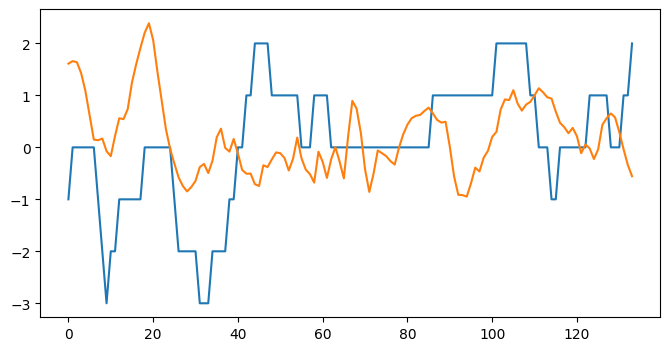

In [39]:
from sklearn.metrics import r2_score
from tools.decoding.lstm import _compute_agg_r2
trial = 10

plt.figure(figsize=(8, 4))
plt.plot(labels[trial, :, 4])
plt.plot(preds[trial, :, 4])

r2_score(preds[trial, :, 4], labels[trial, :, 4])

## Testing

In [56]:
AllData, AllPos= dt.get_data_array_and_pos(
    [pyal.select_trials(df, df.trial_name == 'trial')],
    trial_cat = "values_Sol_direction",
    epoch=Params.perturb_epoch_long, 
    area='MOp', 
    bhv = ["left_knee","right_knee"]
)

M062_2025_03_21_14_00


/home/me24/repos/earthquake-analysis/notebooks/pipelines/../../tools/dataTools.py:302: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [706]
  df = pyal.restrict_to_interval(df, epoch_fun=epoch)
/home/me24/repos/earthquake-analysis/notebooks/pipelines/../../tools/dataTools.py:311: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [706]
  df_ = pyal.restrict_to_interval(data_list[0], epoch_fun=epoch)
/home/me24/repos/earthquake-analysis/notebooks/pipelines/../../tools/dataTools.py:338: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [706]
  df_ = pyal.restrict_to_interval(data_list[0], epoch_fun=epoch)
/home/me24/repos/earthquake-analysis/notebooks/pipelines/../../tools/dataTools.py:357: UserWarning: Dr

M062_2025_03_21_14_00


/home/me24/repos/earthquake-analysis/notebooks/pipelines/../../tools/dataTools.py:361: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_[pos_field][trial] = interpolate_nans(df_[pos_field][trial])
/home/me24/repos/earthquake-analysis/noteboo

In [59]:
AllData.shape

(1, 11, 21, 134, 10)

In [58]:
AllPos.shape

(1, 11, 21, 134, 6)

In [ ]:
arr = dt.get_data_array(
    data_list=[pyal.select_trials(df, df.trial_name == 'trial')],
    area='MOp',
    epoch=Params.perturb_epoch_long
)
n_sessions, n_targets, n_trials, n_time, n_comp = arr.shape
data = arr.reshape((n_targets*n_trials, n_time, n_comp))
data.shape



def get_data_from_df(df):
    arr = dt.get_data_array(
    data_list=[pyal.select_trials(df, df.trial_name == 'trial')],
    area='MOp',
    epoch=Params.perturb_epoch_long
    )
    n_sessions, n_targets, n_trials, n_time, n_comp = arr.shape
    data = arr.reshape((n_targets*n_trials, n_time, n_comp))
    return data




/home/me24/repos/earthquake-analysis/notebooks/pipelines/../../tools/dataTools.py:88: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [706]
  df_ = pyal.restrict_to_interval(data_list[0], epoch_fun=epoch)
/home/me24/repos/earthquake-analysis/notebooks/pipelines/../../tools/dataTools.py:98: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [706]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df


(264, 134, 10)

In [28]:
df_trials = pyal.select_trials(df, df.trial_name == 'trial').iloc[:-1]
# kinematics = np.concatenate()

In [32]:
angles = []
for col in df_trials.columns:
    if col.endswith("angle"):
        angles.append(df_trials[f'{col}'].values)
angles = np.array(angles)

In [48]:
kf = KFold(n_splits=5, shuffle=False)

In [35]:
len(pyal.select_trials(df, df.trial_name == 'trial'))

353

In [22]:
from sklearn.model_selection import KFold


kf = KFold(n_splits=5, shuffle=False)

# Get indices for the first fold
for train_idx, test_idx in kf.split(data):
    print("Train indices:", train_idx.shape)
    print("Test indices:", test_idx.shape)
    break  # just show the first fold

Train indices: (211,)
Test indices: (53,)


In [50]:
from torch.utils.data import DataLoader, Dataset


In [51]:
class TrialDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx]), torch.tensor(
            self.labels[idx], dtype=torch.long
        )